In [4]:
from subprocess import run
import glob
import os
import importlib
import mixing
import pandas as pd
importlib.reload(mixing)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [ ]:
ANIS = ['ANI99', 'ANI90', 'ANI95']
#for ANI, GEN in [('ANI90', '19000'), ('ANI95', '9000'), ('ANI99', '1000')]:
FASTA=f'/manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan/bacmeta_SIDNPOP100NBAC2/nbSjUw/fastas/Generation_GENXX'
FASTQ=f'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANIXX/fastq'
MEGAHIT=f'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANIXX/megahit'
COPAN=f'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANIXX/copan'
EXT_EXE = '/burg/pmg/users/ic2465/copangraph/bin/release/extension'
CPN_EXE = '/burg/pmg/users/ic2465/copangraph/bin/release/copangraph'
CPN_INI='''
# enter all config in 'key = value' format
app_name = cpg
log_file_dir = logs # path relative to the executable
log_level = 0 # possible values are 1ebug=0(includes Info and Error), Info=1(includes Error), Error=2, None=3
log_to = 0 # possible values are Console=0, File=1, ConsoleAndFile=2
sample_list = XSAMPLES 
graph_name = XNAME
out_dir = XOUTDIR 
divergence_threshold = XDT
num_threads = 16
max_separation = 400
window_size = 10
kmer_size = 15
min_homology_overlap = XMINHOMO
min_contiguity_overlap = 60
max_jump = XMAXJUMP # largest allowed gap within an alignment
high_freq_kmer_filter = 1e-5 # remove the top 1-x percentile kmers where x is input
fasta_file_ext = .fasta 
gfa_file_ext = .gfa
node_color_file_ext = .ncolor.csv
edge_color_file_ext = .ecolor.csv
extended_contigs = true 
sensitive_mode = true
asymmetric = false'''

    ## construct sequencing data

    #for fa in glob.glob(os.path.join(FASTA, f'*.fasta')):
    #    base = os.path.splitext(os.path.basename(fa))[0]
    #    base = os.path.join(FASTQ, base)
    #    cmd = f'art_illumina -ss HS25 -rs 42 -p -m 350 -s 10 -f 15 -i {fa} -l 150 -o {base}_'
    #    print(cmd)
    #    run(cmd, shell=True)
    #run(f'pigz -f {FASTQ}/*.fq', shell=True)

In [25]:
# construct sequencing data

for fa in glob.glob(os.path.join(FASTA, f'*.fasta')):
    base = os.path.splitext(os.path.basename(fa))[0]
    base = os.path.join(FASTQ, base)
    cmd = f'art_illumina -ss HS25 -rs 42 -p -m 350 -s 10 -f 15 -i {fa} -l 150 -o {base}_'
    print(cmd)
    run(cmd, shell=True)
run(f'pigz -f {FASTQ}/*.fq', shell=True)

art_illumina -ss HS25 -rs 42 -p -m 350 -s 10 -f 15 -i /manitou/pmg/projects/korem_lab/Projects/bacmeta_for_copan/bacmeta_SIDNPOP100NBAC2/nbSjUw/fastas/Generation_19000/pop_74:rep_0.fasta -l 150 -o /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq/pop_74:rep_0_

    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 6, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------



KeyboardInterrupt: 

In [41]:
FASTQ

'/burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI90/fastq'

In [ ]:
# coassemble data

#pool
print(ANIS)
for a in ANIS:
    FASTQ_ = FASTQ.replace('ANIXX', a)
    r1s = sorted(glob.glob(os.path.join(FASTQ_, '*_1.fq.gz')))
    r1s = ' '.join(r1s)
    cmd = f'zcat {r1s} > {FASTQ_}/pooled_1.fq'
    print(cmd)
    run(cmd, shell=True)
    r2s = sorted(glob.glob(os.path.join(FASTQ_, '*_2.fq.gz')))
    r2s = ' '.join(r2s)
    cmd = f'zcat {r2s} > {FASTQ_}/pooled_2.fq'
    run(cmd, shell=True)

    #compress
    run(f'pigz {FASTQ_}/*.fq', shell=True)




In [ ]:
# run megahit
r1 = f'{FASTQ}/pooled_1.fq.gz'
r2 = f'{FASTQ}/pooled_2.fq.gz'
cmd = f'megahit -t 8 -1 {r1} -2 {r2} -o {MEGAHIT}/coasm'
run(cmd, shell=True)

In [7]:
# run megahit toolkit to make fastg format graphs
for a in ANIS:
    for fa in [e for e in glob.glob(f'{MEGAHIT.replace("ANIXX", a)}/coasm/intermediate_contigs/*.contigs.fa') if 'final' not in e]:
        kval = fa.split('.')[0]
        kval = os.path.basename(kval)
        kval = kval[1:]
        fastg = fa.replace('.contigs.fa', '.fastg')
        cmd = f'megahit_toolkit contig2fastg {kval} {fa} > {fastg}'
        print(cmd)
        run(cmd, shell=True)

megahit_toolkit contig2fastg 29 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediate_contigs/k29.contigs.fa > /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediate_contigs/k29.fastg
megahit_toolkit contig2fastg 59 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediate_contigs/k59.contigs.fa > /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediate_contigs/k59.fastg
megahit_toolkit contig2fastg 141 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediate_contigs/k141.contigs.fa > /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediate_contigs/k141.fastg
megahit_toolkit contig2fastg 21 /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/KmerMixing/bac_meta/ANI99/megahit/coasm/intermediat

In [ ]:
# run single sample assembly
for a in ANIS:
    r1s = sorted(glob.glob(os.path.join(FASTQ.replace('ANIXX', a), '*_1.fq.gz')))
    r2s = sorted(glob.glob(os.path.join(FASTQ.replace('ANIXX', a), '*_2.fq.gz')))
    reads_dict = dict()
    for r1, r2 in zip(r1s, r2s):
        if 'pooled' in r1:
            continue
        base = os.path.basename(r1).split(':')[0]
        reads_dict[base] = (r1, r2)
        cmd = f'megahit -t 8 -1 {r1} -2 {r2} -o {MEGAHIT.replace("ANIXX", a)}/{base}'
        print(cmd)
        run(cmd, shell=True)

In [ ]:
# run paired end extension
for a in ANIS:
    for asm_dir in glob.glob(f'{MEGAHIT.replace("ANIXX", a)}/pop_*'):
        fa = os.path.join(asm_dir, 'final.contigs.fa')
        cmd = f'bowtie2-build --threads 8 {fa} {asm_dir}/idx'
        print(cmd)
        run(cmd, shell=True)
        base = os.path.basename(asm_dir).split(':')[0]
        r1 = FASTQ.replace('ANIXX', a) + '/' + base + ':rep_0_1.fq.gz'
        r2 = FASTQ.replace('ANIXX', a) + '/' + base + ':rep_0_2.fq.gz'
        cmd = f'bowtie2 --threads 6 -x {asm_dir}/idx -1 {r1} -2 {r2} | samtools view -bS - | samtools sort -n -o {asm_dir}/{base}.bam'
        print(cmd)
        run(cmd, shell=True)
        cmd = f'{EXT_EXE} -i {fa} -t 1 --pe-only -b {asm_dir}/{base}.bam -o {asm_dir} -n {base} '
        print(cmd)
        run(cmd, shell=True)


In [1]:
reads_dict

NameError: name 'reads_dict' is not defined

In [6]:
# Setup copangraph
for a in ANIS:
    pe_exts = list()
    for asm_dir in glob.glob(f'{MEGAHIT.replace('ANIXX', a)}/pop_*'):
        base = os.path.basename(asm_dir)
        pe_ext = os.path.join(asm_dir, f'{base}.pe_ext.fasta.gz')
        cmd = f'gunzip {pe_ext}'
        #run(cmd, shell=True)
        pe_exts.append(pe_ext.replace('.gz', ''))

    os.makedirs(COPAN.replace('ANIXX', a), exist_ok=True)
    samples_file = os.path.join(COPAN.replace('ANIXX', a), 'samples.txt')
    with open(samples_file, 'w') as f:
        f.write('\n'.join(pe_exts))


In [9]:
# run copangraph
for a in ANIS:
    samples_file = os.path.join(COPAN.replace('ANIXX', a), 'samples.txt')
    for sd in [0.1, 0.05, 0.01, 0.005]:
        with open(os.path.join(COPAN.replace('ANIXX', a), f'copan_{sd*100}.ini'), 'w') as f:
            f.write(
                CPN_INI.replace('XDT', str(sd))\
                .replace('XNAME', f'copan_sd_{sd*100}')\
                .replace('XMAXJUMP', '500')\
                .replace('XMINHOMO', '1000')\
                .replace('XOUTDIR', COPAN.replace('ANIXX', a))\
                .replace('XSAMPLES', samples_file)
            )
        #ini = os.path.join(COPAN.replace('ANIXX', a), f'copan_{sd*100}.ini')
        #cmd = f'{CPN_EXE} {ini}'
        #print(cmd)
        #run(cmd, shell=True)


In [ ]:
# run mixing analysis
# megahit mixing

k2s = mixing.kmer_to_sample(glob.glob(os.path.join(FASTA, '*.fasta')), mode='freq')

df = pd.DataFrame(columns=['full_name', 'method', 'graph_variable', 'mixing_mean', 'mixing_median', 'mixing_var', 'mixing_sd', 'num_nodes', 'n50', 'num_k_samples', 'num_k_nodes', 'missing_prop'])
for fg in glob.glob(f'{MEGAHIT}/coasm/intermediate_contigs/*.fastg'):

    mix, missing_prop, num_k_samples, num_k_nodes = mixing.mixing(fg, k2s)
    num_nodes = mixing.num_nodes(fg)
    kval = os.path.basename(fg).split('.')[0][1:]
    df.loc[len(df), :] = [f'megahit_{kval}', 'MEGAHIT', int(kval), mix.mean(), mix.median(), mix.var(), mix.std(), num_nodes, pd.NA, num_k_samples, num_k_nodes, missing_prop]



In [28]:
# run mixing analysis
# copan mixing
print('sample calc...')
k2s = mixing.kmer_to_sample(glob.glob(os.path.join(FASTA, '*.fasta')), mode='freq')
for gfa in glob.glob(f'{COPAN}/*.gfa'):
    mix, missing_prop, num_k_samples, num_k_nodes = mixing.mixing(gfa, k2s)
    num_nodes = mixing.num_nodes(gfa)
    seq_div = os.path.basename(gfa).replace('copan_sd_', '').replace('.gfa', '')
    df.loc[len(df), :] = [f'copan_{seq_div}', 'copan', float(seq_div), mix.mean(), mix.median(), mix.var(), mix.std(), num_nodes, pd.NA, num_k_samples, num_k_nodes, missing_prop]
print(df)

sample calc...
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_4;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_2;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_6;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_8;rep_1, seq=ATTCTGATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_0;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_5;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_9;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_3;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_7;rep_1, seq=ATTCTCATGA)
Fasta(hdr=SIDNPOP10NBAC2;gen_9000;pop_1;rep_1, seq=ATTCTCATGA)
node calc...
mixing calc...
node calc...
mixing calc...
node calc...
mixing calc...
node calc...
mixing calc...
      full_name   method graph_variable mixing_mean mixing_median mixing_var  \
0    megahit_59  MEGAHIT             59    0.664538           1.0   0.594711   
1    megahit_79  MEGAHIT             79    0.444969           1.0   0.958196   
2  

9 [-0.32399182 -0.16776094]
11 [ 0.4617761  -0.09889175]


<Figure size 640x480 with 0 Axes>

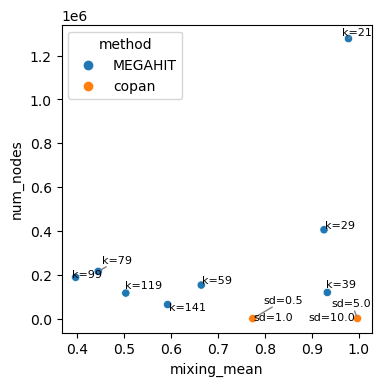

In [30]:
plt.clf()
plt.figure(figsize=(4,4))
sns.scatterplot(x=df.mixing_mean, y=df.num_nodes, hue=df.method)
texts = list()
for i in df.index:
    if df.loc[i, 'method'] == 'MEGAHIT':
        ano = f'k={df.graph_variable[i]}'
    else:
        ano = f'sd={df.graph_variable[i]}'
    #plt.annotate(ano, (df.mixing_mean[i], df.num_nodes[i]), textcoords='offset points', xytext=(5, 5))
    texts.append(plt.text(df.mixing_mean[i], df.num_nodes[i], ano, fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
plt.show()

In [114]:
df

,full_name,method,graph_variable,mixing_mean,mixing_median,mixing_var,mixing_sd,num_nodes,n50,num_k_samples,num_k_nodes,missing_prop
0,megahit_59,MEGAHIT,59,0.793019,1.0,0.33312,0.577165,100685,<NA>,18470423,18515015,0.507155
1,megahit_79,MEGAHIT,79,0.687902,1.0,0.492397,0.70171,94877,<NA>,18470423,18542096,0.507873
2,megahit_99,MEGAHIT,99,0.727134,1.0,0.407498,0.638355,56219,<NA>,18470423,18543874,0.533685
3,megahit_21,MEGAHIT,21,0.978433,1.0,0.013793,0.117444,1272120,<NA>,18470423,18476447,0.082464
4,megahit_119,MEGAHIT,119,0.625228,1.0,0.565498,0.751996,61247,<NA>,18470423,18575728,0.472153
5,megahit_29,MEGAHIT,29,0.925851,1.0,0.03987,0.199675,405168,<NA>,18470423,18471080,0.199662
6,megahit_39,MEGAHIT,39,0.942061,1.0,0.047233,0.217331,110756,<NA>,18470423,18477058,0.432992
7,copan_10.0,copan,10.0,0.996431,1.0,0.00117,0.034201,1490,<NA>,18470423,18478162,0.01394
8,copan_0.5,copan,0.5,0.774425,1.0,0.17419,0.417361,697,<NA>,18470423,18478215,0.002053
9,copan_5.0,copan,5.0,0.99644,1.0,0.001158,0.034024,1495,<NA>,18470423,18478147,0.013806
